# Required Libraries:

In [1]:
# Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
random.seed(101) # fix random seed
# Libraries for folders
import os

# Libraries for opencv
import cv2
%pip install imutils
import imutils

# Libraries for scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Libraries for tensorflow
import tensorflow
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2


Note: you may need to restart the kernel to use updated packages.


# Data Prepare:

In [2]:
# data directory
Data_DIR = "/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset"

# Class labels
clinical_labels = ["COVID19", "NORMAL", "PNEUMONIA", "TUBERCULOSIS"]

# Gathering images and their respective labels in order
X_Images = []
Y_Labels = []
# max, min height & weidth
max_weidth = float('-inf')
min_weidth = float('inf')
max_height = float('-inf')
min_height = float('inf')
# max and min pixels
max_pixel = float('-inf')
min_pixel = float('inf')

for lab in clinical_labels:
    # folder path
    if lab == "TUBERCULOSIS":   # due to spelling mistakes at kaggle input folder directory
        folder_path = os.path.join(Data_DIR, "TURBERCULOSIS") 
    else:
        folder_path = os.path.join(Data_DIR, lab)
    for img in os.listdir(folder_path):
        # image path
        img_path = os.path.join(folder_path, img)
        # read image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (224,224)) # reshaping
        if img is not None:
            # update min,max pixels
            max_pixel = max(max_pixel, image.max())
            min_pixel = min(min_pixel, image.min())

            # update height and weidth
            max_height = max(max_height, image.shape[0])
            min_height = min(min_height, image.shape[0])

            max_weidth = max(max_weidth, image.shape[1])
            min_weidth = min(min_weidth, image.shape[1])

            # update image and label list
            X_Images.append(image)
            Y_Labels.append(lab)
        else:
            print("Invalid Image!")

print("Data has been loaded...")

Data has been loaded...


In [3]:
#print the pixels information
print(f'Maximum pixel value: {max_pixel}')
print(f'Minimum pixel value: {min_pixel}')

# Print the image height and weidth informations
print(f'\nMaximum height value: {max_height}')
print(f'Minimum height value: {min_height}')

print(f'\nMaximum weidth value: {max_weidth}')
print(f'Minimum weidth value: {min_weidth}')

Maximum pixel value: 255
Minimum pixel value: 0

Maximum height value: 224
Minimum height value: 224

Maximum weidth value: 224
Minimum weidth value: 224


In [4]:
# Total number of sample
num_sample = len(X_Images)
print(f"Total number of sample is:{num_sample}")

Total number of sample is:7132


### Visualize some raw images:

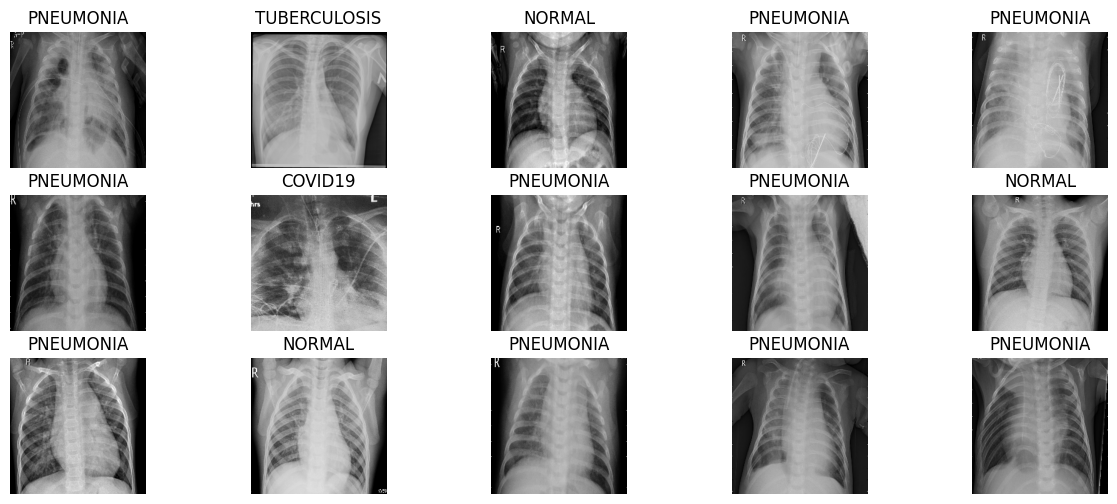

In [6]:
# number of images
num_img = 15
# plot size
plt.figure(figsize=(15,6))
# random sample
random_idx = random.sample(range(num_sample),num_img)
for i in range(num_img):
    plt.subplot(num_img//5,5,i+1) # 3 rows and 5 columns
    plt.imshow(X_Images[random_idx[i]], cmap='gray')
    plt.axis('off')
    plt.title(f"{Y_Labels[random_idx[i]]}")
plt.show()

# Image Pre-Processing:

### White Balance Approach:

**White balance** plays a crucial role in medical imaging, especially when analyzing chest X-rays (CXR) for the diagnosis of viral infections like COVID-19, pneumonia, tuberculosis, and others. In medical imaging, the goal is often to make the key features of the image (such as the lungs and surrounding tissues) clearly distinguishable from the rest of the image.

**Lungs** typically appear black (or very dark) on chest X-rays because they are air-filled and absorb fewer X-rays compared to the surrounding tissues, such as bones and muscles. The dark areas represent low-density structures, which is important for visualizing the lungs in a chest X-ray.

**Bones, organs, and tissues**, on the other hand, appear white or light gray because they absorb more X-rays, leading to a higher density in the image.

We will apply white balance to improve the visuality of lungs:

In [5]:
# white balace for each channel
def WB_channel(channel, perc=0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel, 100-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel
# White balance to an image
def WB_image(img):
    img = img.copy()
    imwb = np.dstack([WB_channel(channel, 0.05) for channel in cv2.split(img)]) # this is color wb image
    imwb_gray = cv2.cvtColor(imwb, cv2.COLOR_BGR2GRAY) # as original image in BGR format
    # return gray and color image
    return imwb_gray, imwb

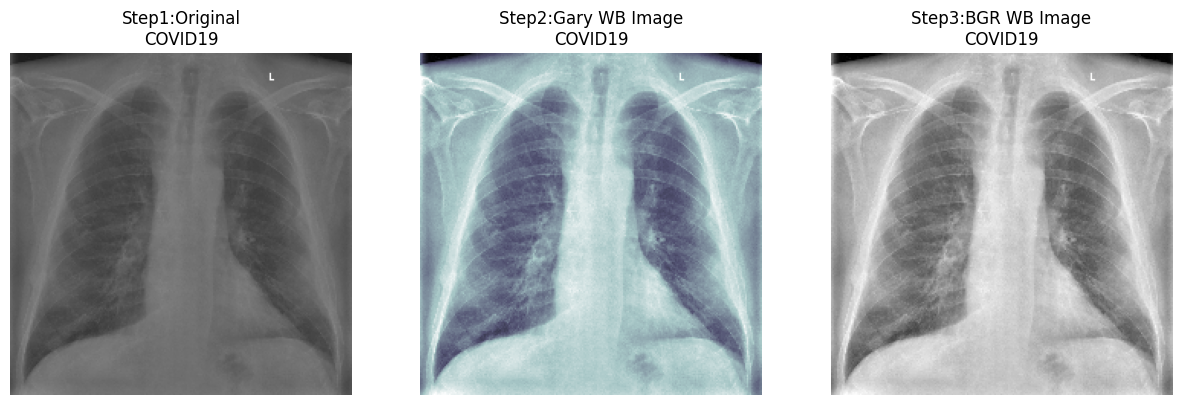

In [6]:
img = X_Images[0]
imgwb_gray, imwb_BGR = WB_image(img)
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.imshow(img, cmap='bone')
plt.title(f"Step1:Original\n{Y_Labels[0]}")
plt.axis('off')
plt.subplot(132)
plt.imshow(imgwb_gray, cmap="bone")
plt.title(f"Step2:Gary WB Image\n{Y_Labels[0]}")
plt.axis('off')
plt.subplot(133)
plt.imshow(imwb_BGR, cmap="bone")
plt.title(f"Step3:BGR WB Image\n{Y_Labels[0]}")
plt.axis('off')
plt.show()

We have visualized the white balance filtered image in both gary and BGR format. During DL model, we will proceed with BGR format to preserve all important features along all the channels.

In [7]:
X_Images[0].shape

(224, 224, 3)

In [8]:
# Apply White balance on all the images
X_imwb = []
for img in X_Images:
    # Apply WB on img
    _, imwb_BGR = WB_image(img) # only hold BGR format
    X_imwb.append(imwb_BGR)
    
print("WB has applied...")

WB has applied...


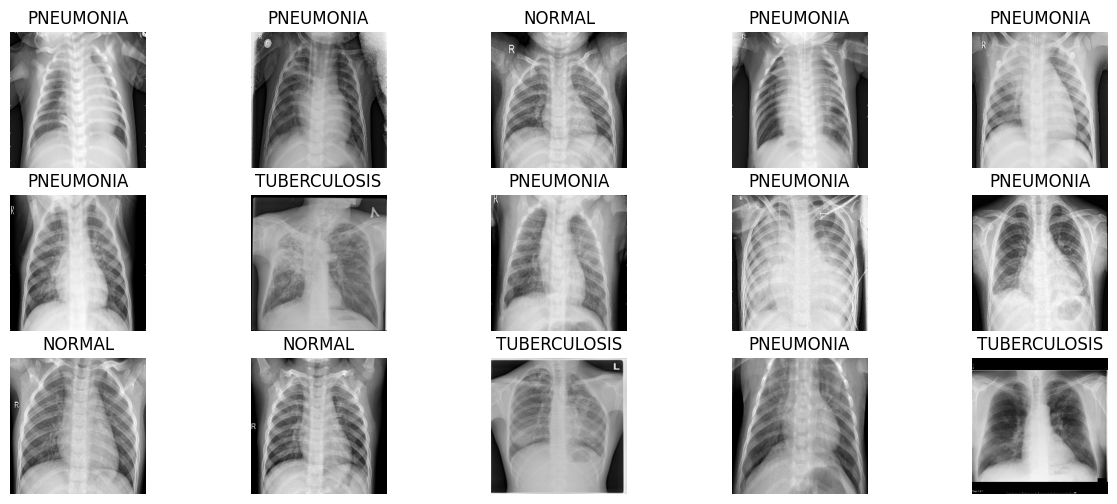

In [93]:
# Visualize WB images
# number of images
num_img = 15
# plot size
plt.figure(figsize=(15,6))
# random sample
random_idx = random.sample(range(num_sample),num_img)
for i in range(num_img):
    plt.subplot(num_img//5,5,i+1) # 3 rows and 5 columns
    plt.imshow(X_imwb[random_idx[i]], cmap='gray')
    plt.axis('off')
    plt.title(f"{Y_Labels[random_idx[i]]}")
plt.show()

# Normalize the images:

In [11]:
X_imwb_norm = []
for img in X_imwb:
    img_norm = (img/255.0).astype('float32') # range of each pixesl in each image becomes [0,1]
    X_imwb_norm.append(img_norm)
print('Normalized has done....')

Normalized has done....


# Class Distribution:

In [14]:
# Convert all the list into np array
X_imwb_norm = np.array(X_imwb_norm)
Y_labels = np.array(Y_Labels)

In [15]:
# Counts for each types of tumor:
pd.DataFrame(list(Counter(Y_labels).items()), columns=['Class', 'Count'])

Class  Count
0       COVID19    576
1        NORMAL   1583
2     PNEUMONIA   4273
3  TUBERCULOSIS    700

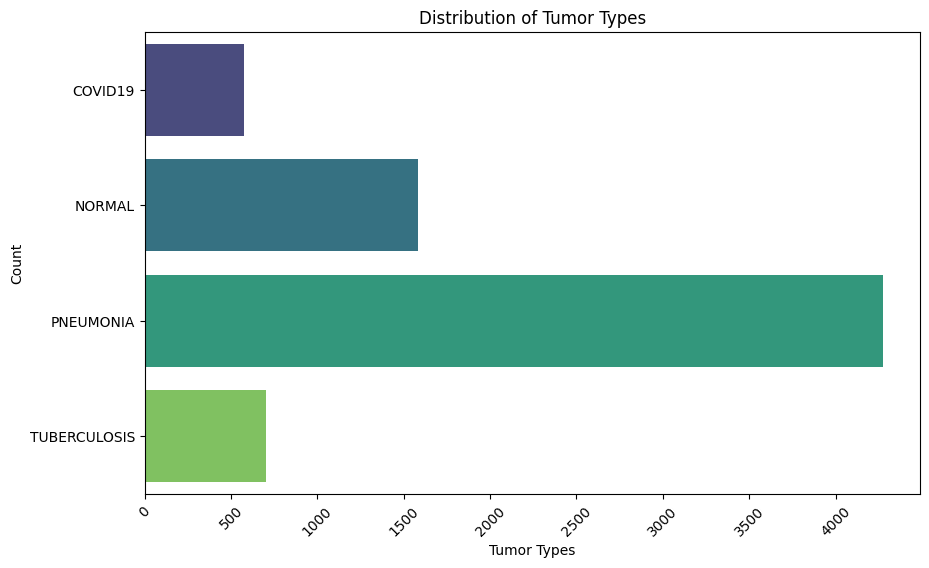

In [16]:
#Plot using Seaborn's countplot with 'viridis' palette
plt.figure(figsize=(10, 6))
sns.countplot(y=Y_labels, palette='viridis')  # Use data frame with hue
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.xlabel('Tumor Types')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.title('Distribution of Tumor Types')  # Title of the plot
plt.show()

Clearly we have imbalanced dataset. We need to handle it carefully for robust and better generalize DL&AI predictor model.

# Splits the entire dataset into train and test randomly using stratified splitting:

**Stratified** splitting ensures that the class distribution in our dataset is preserved across training and test sets. This is particularly important for imbalanced datasets to prevent over-representation or under-representation of certain classes during model evaluation. The split is performed based on the labels (target variable) so that the proportion of each class in the original dataset is reflected in both the train and test sets. In Python, this can be implemented using **stratify** in **train_test_split** from **sklearn**. It is especially useful in classification problems where maintaining class balance is crucial.

In [17]:
#stratified splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_imwb_norm, Y_labels, test_size=0.2, stratify=Y_labels, random_state=42
)

print('Spliting into 80-20 has done!')

Spliting into 80-20 has done!


Class  Count
0     PNEUMONIA   3418
1  TUBERCULOSIS    560
2        NORMAL   1266
3       COVID19    461

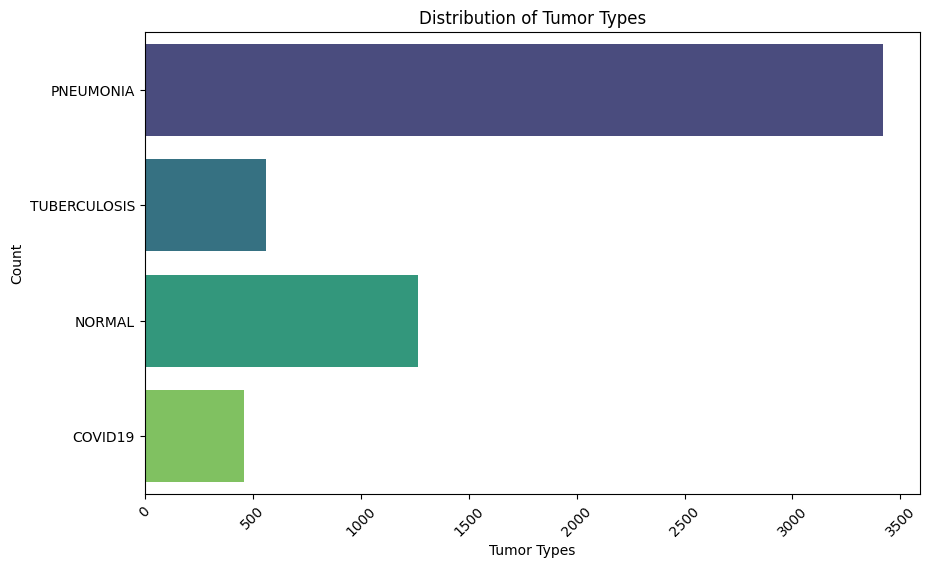

In [18]:
# Distribution of class in training set
display(pd.DataFrame(list(Counter( y_train).items()), columns=['Class', 'Count']))

# Barplots
#Plot using Seaborn's countplot with 'viridis' palette
plt.figure(figsize=(10, 6))
sns.countplot(y= y_train, palette='viridis')  # Use data frame with hue
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.xlabel('Tumor Types')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.title('Distribution of Tumor Types')  # Title of the plot
plt.show()

# Convert categorical label into numeric values & one-hot representations:

In [19]:
# category to numeric
label_encoder = LabelEncoder()
# fit on tarin set
y_train_encoded = label_encoder.fit_transform(y_train)
# transform on test set
y_test_encoded = label_encoder.transform(y_test)

print("Encoded has done!")

Encoded has done!


In [20]:
# Get the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label mapping:", label_mapping)

Label mapping: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TUBERCULOSIS': 3}


In [21]:
# Integer label to One-hot conversion
y_train_one_hot = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))
y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(label_encoder.classes_))

print("One-hot conversion has done!")

One-hot conversion has done!


In [22]:
print(f"Before Encoding: {y_test}")
print(f"After Encoding: {y_test_encoded}")
print(f"After one-hot representation: {y_test_one_hot}")

Before Encoding: ['NORMAL' 'PNEUMONIA' 'PNEUMONIA' ... 'PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA']
After Encoding: [1 2 2 ... 2 2 2]
After one-hot representation: [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [23]:
# Esure all the sets have same formate
print('Train image: ', type(X_train))
print('Train label: ', type(y_train_one_hot))
print('Test image: ',  type(X_test))
print('Train label: ', type(y_test_one_hot))

Train image:  <class 'numpy.ndarray'>
Train label:  <class 'numpy.ndarray'>
Test image:  <class 'numpy.ndarray'>
Train label:  <class 'numpy.ndarray'>


Thus we have

* training set as : **(X_train, y_train_one_hot)**
* test set as:  **(X_test, y_test_one_hot)**
ot)

# Model Building:

### Load base line model for feature extraction:

In [24]:
# Load the  MobileNetV2 as base model with out top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

### Define the custome dense layers on top:

In [25]:
# Custome Top Dense layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)  # Since our number of class is 4

In [26]:
# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compiles the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
# model.summary()

In [27]:
# plot the model architecture:
# plot_model(model, to_file="Model_Architecture.png", show_shapes=True, show_layer_names=True)

In [28]:
# Early stoping
early_stop = EarlyStopping(monitor ='val_loss', patience=5, restore_best_weights=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor ='val_loss', factor=0.3, patience=2, min_lr=1e-10,verbose=1)
    
# Add ModelCheckpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('Best_Model_On_Partial1.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1) 

### Train model on train set:

### Image Generator:

In [29]:
# Data generator for training set
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)

In [30]:
# fits the model on our dataset
history1 = model.fit(train_datagen.flow(X_train, y_train_one_hot),
                    epochs = 50,
                    batch_size = 32,
                    validation_data=(X_test, y_test_one_hot), 
                    verbose = 1,
                    callbacks=[early_stop,reduce_lr, model_checkpoint]
) 

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733323310.188946    3857 service.cc:145] XLA service 0x7af1b8003790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733323310.189025    3857 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733323310.189031    3857 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/179 ━━━━━━━━━━━━━━━━━━━━ 2:46:34 56s/step - accuracy: 0.2500 - loss: 1.8020

I0000 00:00:1733323340.714190    3857 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6696 - loss: 0.9282
Epoch 1: val_loss improved from inf to 16.81364, saving model to Best_Model_On_Partial1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 139s 466ms/step - accuracy: 0.6704 - loss: 0.9264 - val_accuracy: 0.1640 - val_loss: 16.8136 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9171 - loss: 0.3151
Epoch 2: val_loss did not improve from 16.81364
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 285ms/step - accuracy: 0.9171 - loss: 0.3149 - val_accuracy: 0.1065 - val_loss: 18.5261 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9325 - loss: 0.2299
Epoch 3: val_loss improved from 16.81364 to 9.15336, saving model to Best_Model_On_Partial1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 287ms/step - accuracy: 0.9325 - loss: 0.2300 - val_accuracy: 0.1100 - val_loss: 9.1534 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9405

According to above training informations, the model that has been saved has training **accuray:0.9911 - loss: 0.0343 - val_accuracy: 0.9769 - val_loss: 0.0616** at epoch 18.

# Performance Metrics:

### Load trained model:

In [31]:
Predicted_model = load_model('/kaggle/working/Best_Model_On_Partial1.keras')  # Load your saved model
print(f'Trained model Best_Model.keras has loaded')

Trained model Best_Model.keras has loaded


In [32]:
# predictions on test set
batch_size = 32  # Adjust batch size based on your GPU memory capacity
pred_lab_dist = []
for i in range(0, len(X_test), batch_size):
    batch = X_test[i:i+batch_size]
    batch_pred = Predicted_model.predict(batch,verbose=0)
    pred_lab_dist.append(batch_pred)

# Concatenate all batch predictions
pred_lab_dist = np.concatenate(pred_lab_dist, axis=0)

# true label
Y_true = y_test_encoded
# predicted  label
Y_pred = np.argmax(pred_lab_dist, axis=-1)

# Classification report
cls_rep = classification_report(Y_true,Y_pred)
print(f'Classification report:\n {cls_rep}')

# Confusion matrix
cnf_mtx = confusion_matrix(Y_true,Y_pred)
print(f'Confusion matrix:\n {cnf_mtx}')

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       115
           1       0.96      0.96      0.96       317
           2       0.98      0.99      0.99       855
           3       0.99      0.96      0.97       140

    accuracy                           0.98      1427
   macro avg       0.97      0.97      0.97      1427
weighted avg       0.98      0.98      0.98      1427

Confusion matrix:
 [[111   1   2   1]
 [  0 303  14   0]
 [  0   9 846   0]
 [  5   1   0 134]]


### Performance metrics plots:

### Accuracy & Loss plots:

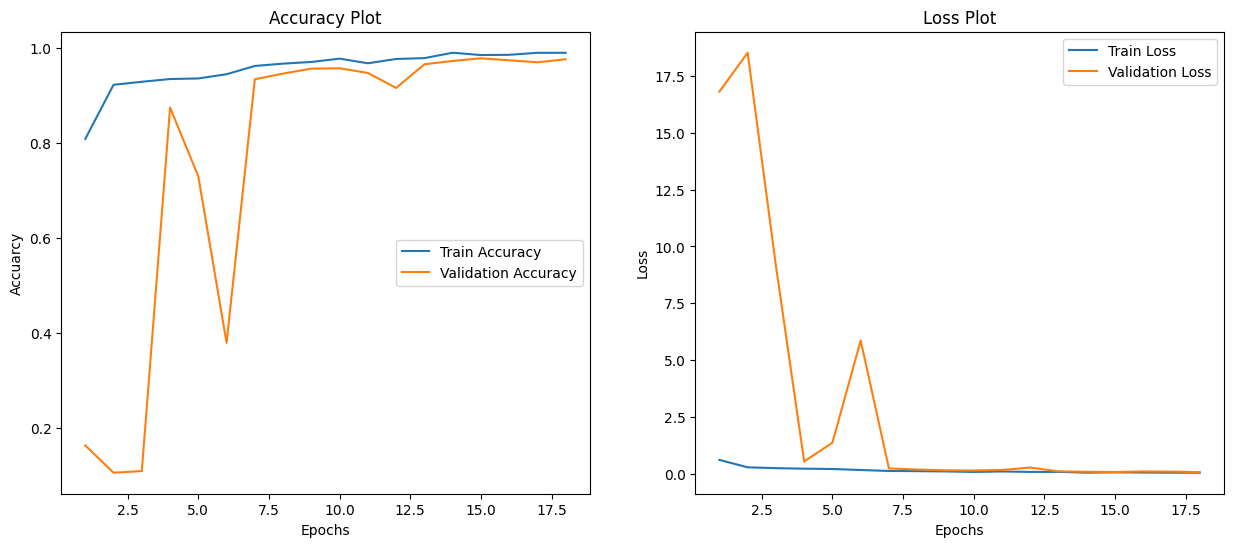

In [43]:
# figure size
plt.figure(figsize=(15,6))

# Training accuracy and validation accuracy
train_acc = history1.history['accuracy']
val_acc   = history1.history['val_accuracy']
epochs = range(1,19) # as best performance at epoch 18
plt.subplot(1,2,1)
plt.plot(epochs,train_acc[:18],label='Train Accuracy')
plt.plot(epochs,val_acc[:18],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.title('Accuracy Plot')
plt.legend(loc='center right')

# Training and validation losses
train_loss = history1.history['loss']
val_loss   = history1.history['val_loss']
plt.subplot(1,2,2)
plt.plot(epochs,train_loss[:18],label='Train Loss')
plt.plot(epochs,val_loss[:18],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(loc='upper right')

plt.show()


### Confusion matrix plot:

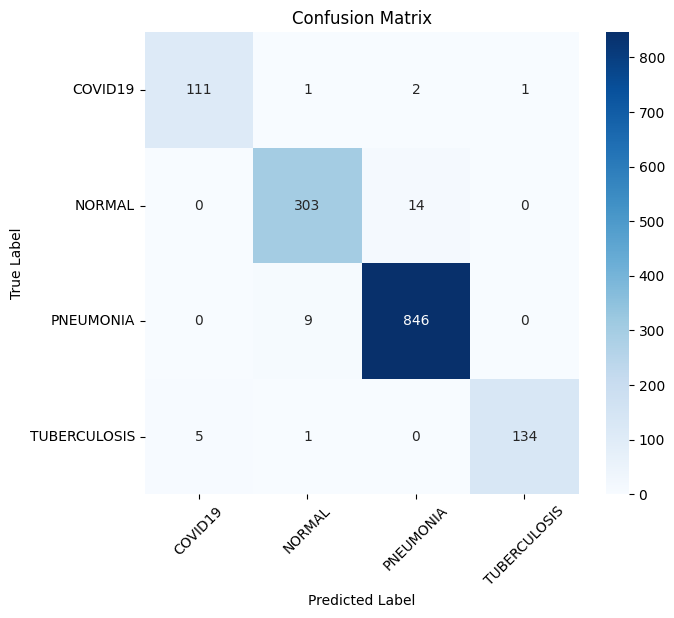

In [34]:
# Plot confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cnf_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=clinical_labels, yticklabels=clinical_labels)
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.ylabel('True Label')
plt.yticks(rotation=0)
plt.title('Confusion Matrix') 
plt.show()

# Predicting Viral infection on unseen Chest X-Ray:

### Image PreProcessing:

In [35]:
# white balace for each channel
def WB_channel(channel, perc=0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel, 100-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel
# White balance to an image
def WB_image(img):
    img = img.copy()
    imwb = np.dstack([WB_channel(channel, 0.05) for channel in cv2.split(img)]) # this is color wb image
    imwb_gray = cv2.cvtColor(imwb, cv2.COLOR_BGR2GRAY) # as original image in BGR format
    # return gray and color image
    return imwb_gray, imwb

In [36]:
# Function to perform complete image processing:
def Image_PreProcessed(img,wb=None,target_size=(224,224)):
    img = img.copy()
    if wb is not None:
        _,img = wb(img)
    # resize
    img = cv2.resize(img, dsize=target_size)
    
    # # Normalize
    img = (img/255.0).astype('float32')

    # return processed image
    return img

In [37]:
# Read images
img_dir = "/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset"
# Image labels
img_labels = ["COVID19", "NORMAL", "PNEUMONIA", "TURBERCULOSIS"]
# Image paths
img_folders = [(os.path.join(img_dir,lab),lab) for lab in img_labels] # (folder,labels) pairs

In [38]:
img_folders

[('/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/COVID19',
  'COVID19'),
 ('/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/NORMAL',
  'NORMAL'),
 ('/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA',
  'PNEUMONIA'),
 ('/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/TURBERCULOSIS',
  'TURBERCULOSIS')]

In [39]:
# Extract 5 images from each of types
images = [(os.listdir(img_folder)[:5],lab,img_folder) for img_folder,lab in img_folders]
print(images)

[(['COVID19(189).jpg', 'COVID19(65).jpg', 'COVID19(239).jpg', 'COVID19(101).jpg', 'COVID19(303).jpg'], 'COVID19', '/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/COVID19'), (['NORMAL2-IM-0771-0001.jpeg', 'NORMAL2-IM-0336-0001.jpeg', 'NORMAL2-IM-1294-0001-0002.jpeg', 'IM-0675-0001.jpeg', 'NORMAL2-IM-1169-0001.jpeg'], 'NORMAL', '/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/NORMAL'), (['person1180_virus_2010.jpeg', 'person1676_virus_2892.jpeg', 'person1230_virus_2081.jpeg', 'person1513_virus_2632.jpeg', 'person124_virus_238.jpeg'], 'PNEUMONIA', '/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA'), (['Tuberculosis-173.png', 'Tuberculosis-334.png', 'Tuberculosis-309.png', 'Tuberculosis-487.png', 'Tuberculosis-178.png'], 'TURBERCULOSIS', '/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/TURBERCULOSIS')]


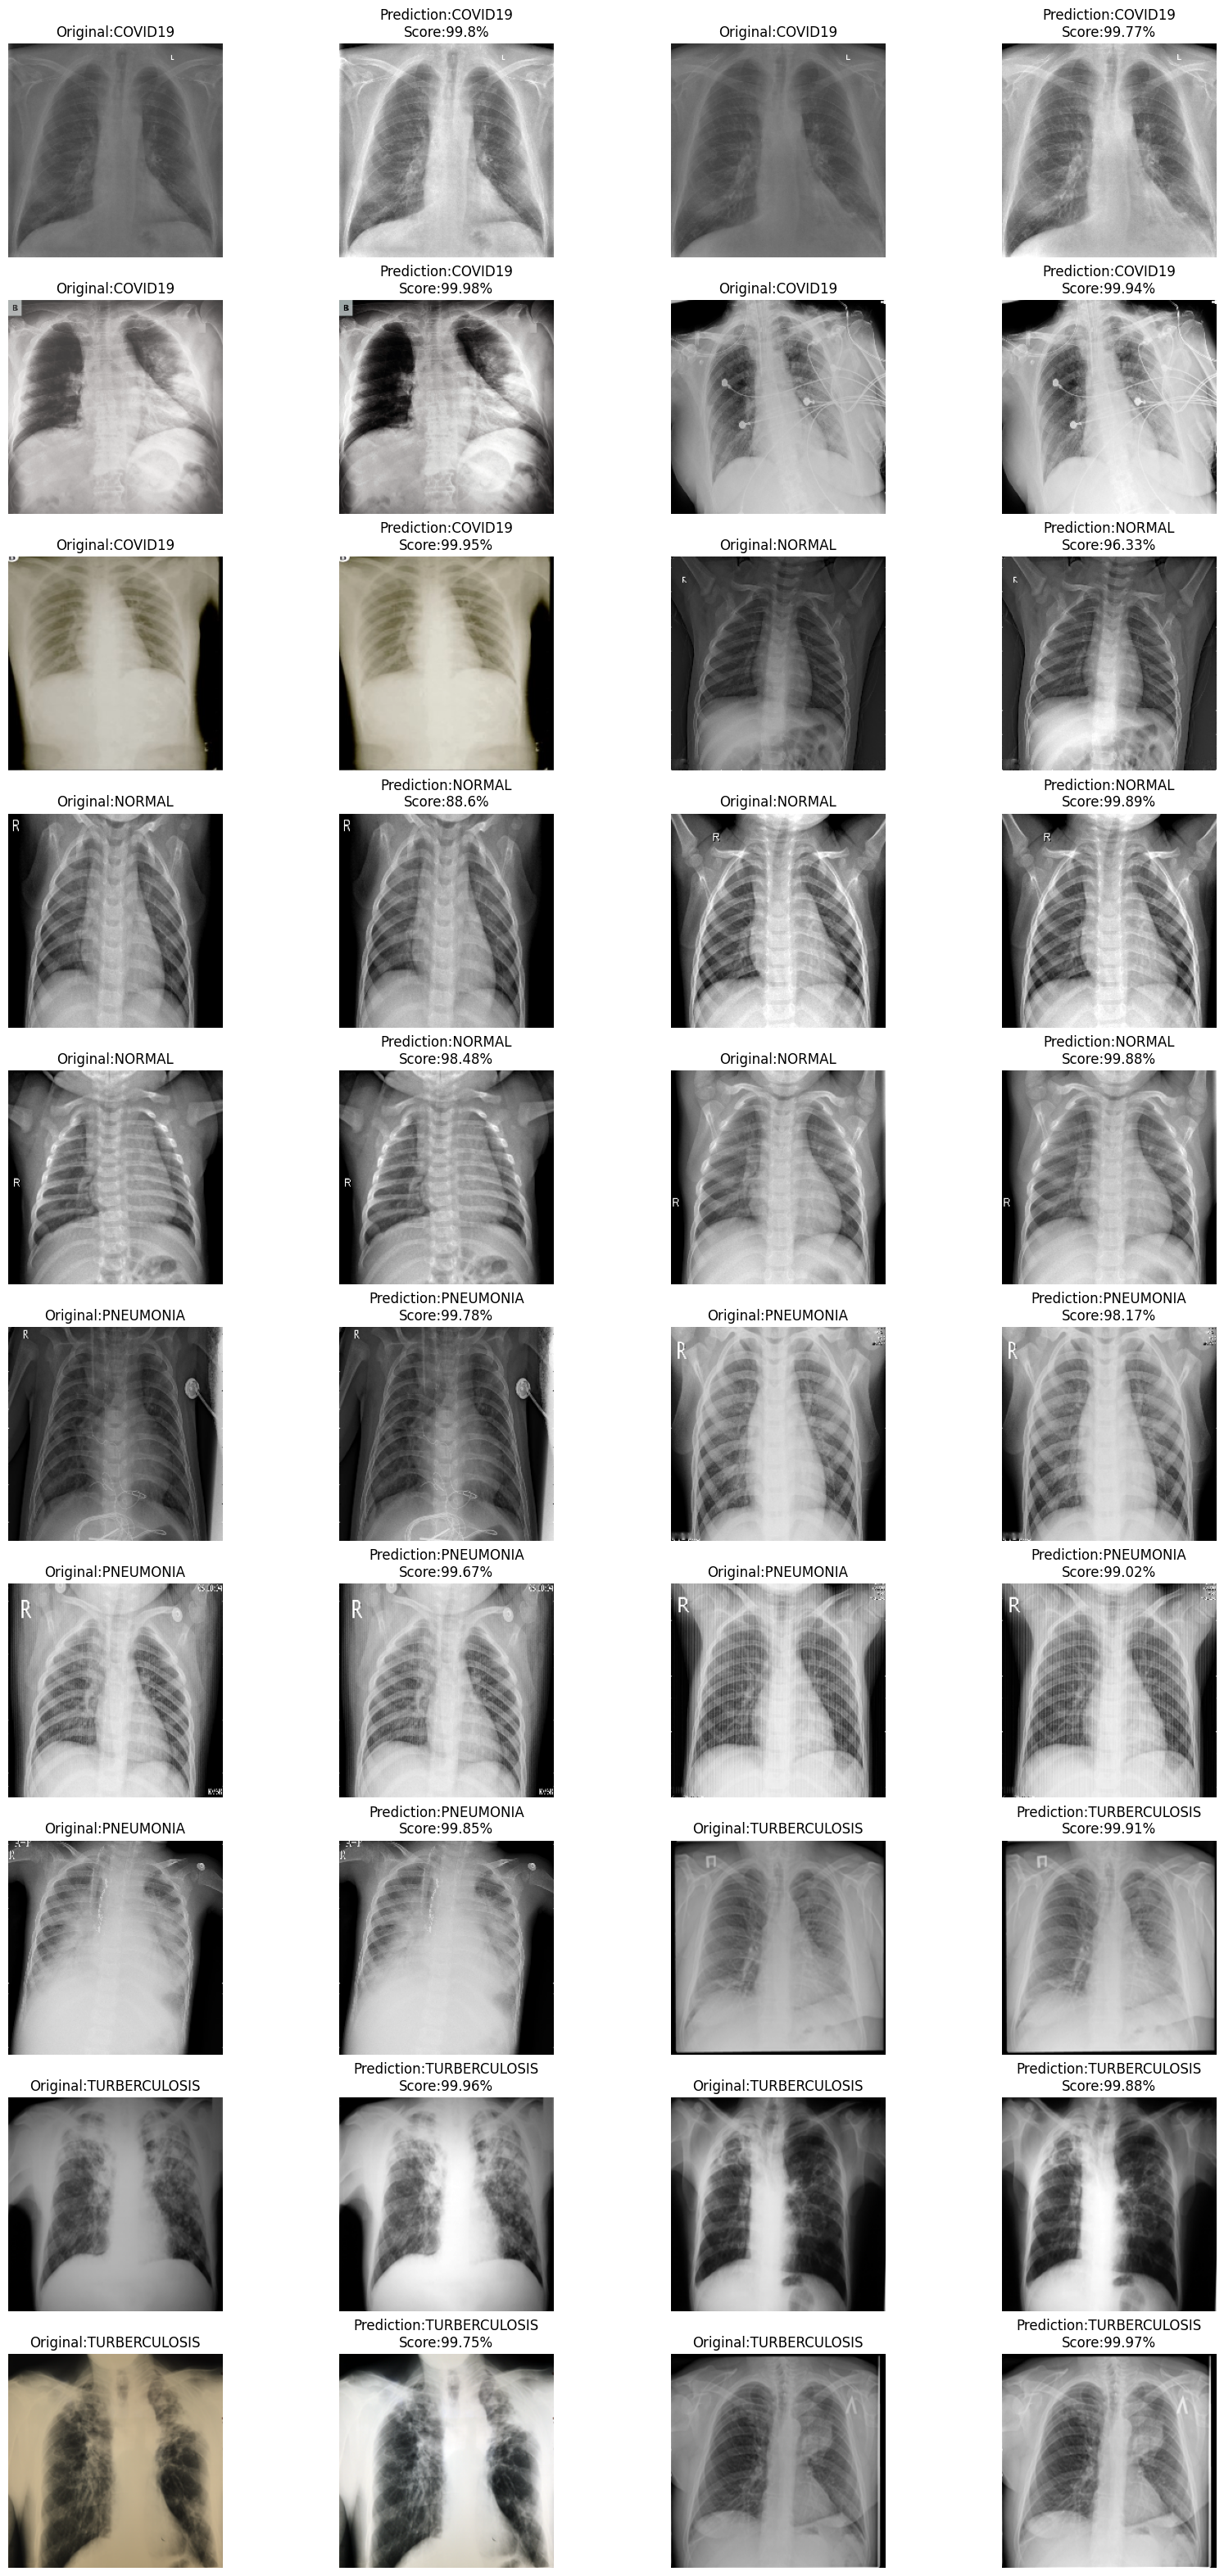

In [40]:
# predicts the viral types on each unseen data
# plot figure
# Calculate rows and columns dynamically
n_images = 5*len(images) * 2  # Original  + predicting
cols = 4
rows = (n_images + cols - 1) // cols  # Round up to fit all images
plt.figure(figsize=(20,rows*4))
i = 1
for imgs,lab,folder in images:
    original_label = lab
    for img in imgs:
        # read image
        image_path = os.path.join(folder,img)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224,224))  # Resize to the expected input size
        # Original image
        plt.subplot(rows,cols,i)
        plt.imshow(image,cmap='bone')
        plt.title(f'Original:{original_label}')
        plt.axis('off')
        
        # Predicted type with score on processed image
        image_pro = Image_PreProcessed(image,wb=WB_image)
        # Dynamically reshape , since target size is (1,224,224,3), 1 for batch size for single image
        target_shape = (1, *image_pro.shape)  # (1, height, width, channels)
        image_pro_re = image_pro.reshape(target_shape)
        predictions = Predicted_model.predict(image_pro_re,verbose=0)
        predicted_label = np.argmax(predictions, axis=-1)[0]  # Get the index of the highest probability
        predicted_score = np.max(predictions,axis=-1)[0]
        plt.subplot(rows,cols,i+1)
        plt.imshow(image_pro, cmap='bone')
        plt.title(f'Prediction:{img_labels[predicted_label]}\nScore:{np.round(predicted_score*100,2)}%')
        plt.axis('off')
        i+=2
plt.show()

> **THANK YOU**